In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os
import pandas as pd
import matplotlib.offsetbox as offsetbox

In [2]:
# Dictionary of standard (LEADER) model colours
col_dict = {'ACCESS-ESM1-5':'#7f3c8d','CanESM5':'#11a579','CMCC-CM2-SR5':'#3969ac','CNRM-CM6-1':'red','FGOALS-g3':'#f2b701','GISS-E2-1-G':'#e73f74','HadGEM3-GC31-LL':'#80ba5a','IPSL-CM6A-LR':'#e68310','MIROC6':'#008695','MPI-ESM1-2-LR':'#cf1c90','NorESM2-LM':'#f97b72'}
exp_col_dict = {"hist-totalO3": "#66c5cc",
	"hist-sol": 	"#f6cf71",
	"hist-volc":	"#f89c74",
	"unlabeled_1":  "#dcb0f2",  # rename if needed    
	"hist-aer": 	"#87c55f",
	"unlabeled_2":  "#9eb9f3",  # rename if needed
	"hist-GHG": 	"#fe88b1",
	"hist-nat": 	"#c9db74",
	"hist-total03":  "#8be0a4",  # rename if needed    
	"historical":   "#b497e7",
	"observations": "#b3b3b3"
}

In [3]:
def calculate_NAO_trend(filepath, year_init, year_final, period_init, variable, time_variable):

    #creating an empty array for the trend which will be appended to and then outputted
    #got to convert into amount of years between, there is a +1 due to python's indexing finishing before the last one (I want to include 0 and end)
    #not currently outputting the intercept but could I I need it
    NAO_trend_slope = np.zeros(year_final - year_init - period_init)
    NAO_trend_intercept = np.zeros(year_final - year_init - period_init)
    
    #opening dataset
    ds = xr.open_dataset(filepath)
    
    period_end = (year_init + period_init)
    trend_period = period_init
    i = 0

    while period_end < year_final:
        #Taking slice of dataset to perform the linregress on
        ds_slice = ds[variable].sel({time_variable: slice(year_init,year_init+trend_period)}).values
        
        # time as a simple integer array, the +1 comes from matching to the line above when slicing between initial year and initial year + trend period.        
        time_numeric = np.arange(trend_period+1)

        # Perform the regression using linregress (returns slope, intercept, r_value, p_value, std_err)
        reg_slope, reg_intercept, _, _, _ = linregress(time_numeric, ds_slice)
    
        # Store the results within the arrays made earlier
        NAO_trend_slope[i] = reg_slope
        NAO_trend_intercept[i] = reg_intercept

        #increasing the enddate, trend_period ( to update the numeric time array) and the index i.
        period_end = period_end + 1
        trend_period = trend_period + 1
        i = i + 1
        

    return NAO_trend_slope

def get_ensemble_means_timeseries_files(folder_path):
    #function which will loop through a folder (my folders are by experiment) to find all the relevant EM files
    ens_means_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if '_EM_' in filename]
    return ens_means_files

def get_multimodel_mean(files, variable):
    #this will open each file within files (list)
    #then calculate the mean across them (multimodel mean)
    #then it will output this data as an array

    data_arrays = []
    
    #looping over all files
    for file in files:
        #opening the dataset for one file
        ds = xr.open_dataset(file, engine='netcdf4')

        #appending the timeseries data to the array
        data_arrays.append(ds[variable])

    #calculating the mean
    multimodel_mean = np.mean([da.values for da in data_arrays], axis=0)

    #creating an array of the mean
    multimodel_da = xr.DataArray(multimodel_mean, coords=data_arrays[0].coords, dims=data_arrays[0].dims)

    return multimodel_da


In [14]:
#FIGURE a) DATA ANALYSIS

#seting up the time period to calculate the trend over and the length of the trend period to start with
year_init = 1979
year_final = 2015
period_init = 10
time = np.arange(year_init+period_init, year_final)

#finding the ERA5 trend
variable = 'nao_timeseries_djf'
filepath = '/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/ERA5_2020/ERA5_1.cvdp_data.1940-2020.nc'
era5_trend = calculate_NAO_trend(filepath, year_init, year_final, period_init, variable, 'TIME') * 10
era5_trend_PDF = calculate_NAO_trend(filepath, year_init, year_final, 35, variable, 'TIME') * 10

#finding the ensemble and ensemble mean trends.
#setting up variables
variable = 'psl'

#creating empty dictionaries to store the trend timeseries
ensemble_mean_trend = {}
ensembles_trend = {}

#providing the list of models (each model has its own folder with the ensemble and ensemble mean data)
model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']#for historical - removed GISS as issues with time on that one.

for m in model:
    #looping through each model to find the filenames of the nao timeseries for each ensemble member and ensemble_mean
    folderpath = '/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAO/historical/' + m + '/'
    filepaths = [os.path.join(folderpath, filename) for filename in os.listdir(folderpath) if m in filename and '_EM_' not in filename]
    filepaths_EM = [os.path.join(folderpath, filename) for filename in os.listdir(folderpath) if m in filename and '_EM_' in filename]

    #finding the trend timeseries adn then appending it to the data structures for both the ensemble members and ensemble mean
    ensembles_trend[m] = []
    for i in range(0,len(filepaths)):
        trend = calculate_NAO_trend(filepaths[i],year_init, year_final, period_init, variable, 'year')
        ensembles_trend[m].append(trend * 10)

    ensemble_mean_trend[m] = []
    for i in range(0,len(filepaths_EM)):
        trend_EM = calculate_NAO_trend(filepaths_EM[i],year_init, year_final, period_init, variable, 'year')
        ensemble_mean_trend[m].append(trend_EM * 10)

In [15]:
#FIGURE b) DATA ANALYSIS

#Basically use the same function as before but want only to longest trend period. Make period_init biggest it can be.
year_init = 1979
year_final = 2015
period_init = year_final - year_init - 1

ensembles_trend_PDF = {}

for m in model:
    #looping through each model to find the filenames of the nao timeseries for each ensemble member and ensemble_mean
    folderpath = '/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAO/historical/' + m + '/'
    filepaths = [os.path.join(folderpath, filename) for filename in os.listdir(folderpath) if m in filename and '_EM_' not in filename]

    #finding the longest trend and then appending this to the data structure
    ensembles_trend_PDF[m] = []
    for i in range(0,len(filepaths)):
        trend_PDF = calculate_NAO_trend(filepaths[i],year_init, year_final, period_init, variable, 'year')
        ensembles_trend_PDF[m].append(trend_PDF.item() * 10)

#finding the max and mins of all the data to then create good bins.
all_data = [slope for slopes in ensembles_trend_PDF.values() for slope in slopes]
data_min = min(all_data)  # Minimum value in the data
data_max = max(all_data)  # Maximum value in the data

# Define the number of bins you want
num_bins = 25

# Calculate the bin edges with equal width
bin_edges = np.linspace(data_min, data_max, num_bins + 1)  # +1 because bin_edges has one more edge than bins

# Create an array to accumulate the data for the stacked histogram
hist_data = []
colors = []  # Store colors for each model

for m in model:
    hist, _ = np.histogram(ensembles_trend_PDF[m], bins=bin_edges)
    hist_data.append(hist)
    colors.append(col_dict[m])

hist_data = np.array(hist_data)

In [16]:
#FIGURE c) DATA ANALYSIS

#setting up variables and list of experiments to loop through
mode = 'NAO'
variable = 'psl'
experiment =['historical','hist-aer','hist-GHG','hist-totalO3','hist-sol','hist-volc']
times = np.arange(1850, 2015)

experiment_mmm = {}

#looping through each experiment to a folder with every models ensemble mean saved. Different folder for each experiment
for e in experiment:
    folder_path = '/gws/nopw/j04/extant/users/slbennie/projection_indicies/'+mode+'/' + e + '/model_ens_means/' 

    #callin function to get all the file names of the ensemble means
    ens_means_files = get_ensemble_means_timeseries_files(folder_path)

    #calling function to calculate the multi-model ensemble mean if given a list of files
    multimodel_da = get_multimodel_mean(ens_means_files, variable)

    #assigning multi-model ensemble means to a data structure to loop through by experiment for calculating a rolling mean and then plotting
    experiment_mmm[e] = multimodel_da.values

window_size = 10

for e in experiment:
    running_mean_mmm = pd.Series(experiment_mmm[e]).rolling(window=window_size, center=True).mean()

#Now time for ERA5
era5 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/ERA5_1.cvdp_data.1940-2014.nc')
era5_timeseries = era5['nao_timeseries_djf']
era5_times = np.arange(1940,2015)

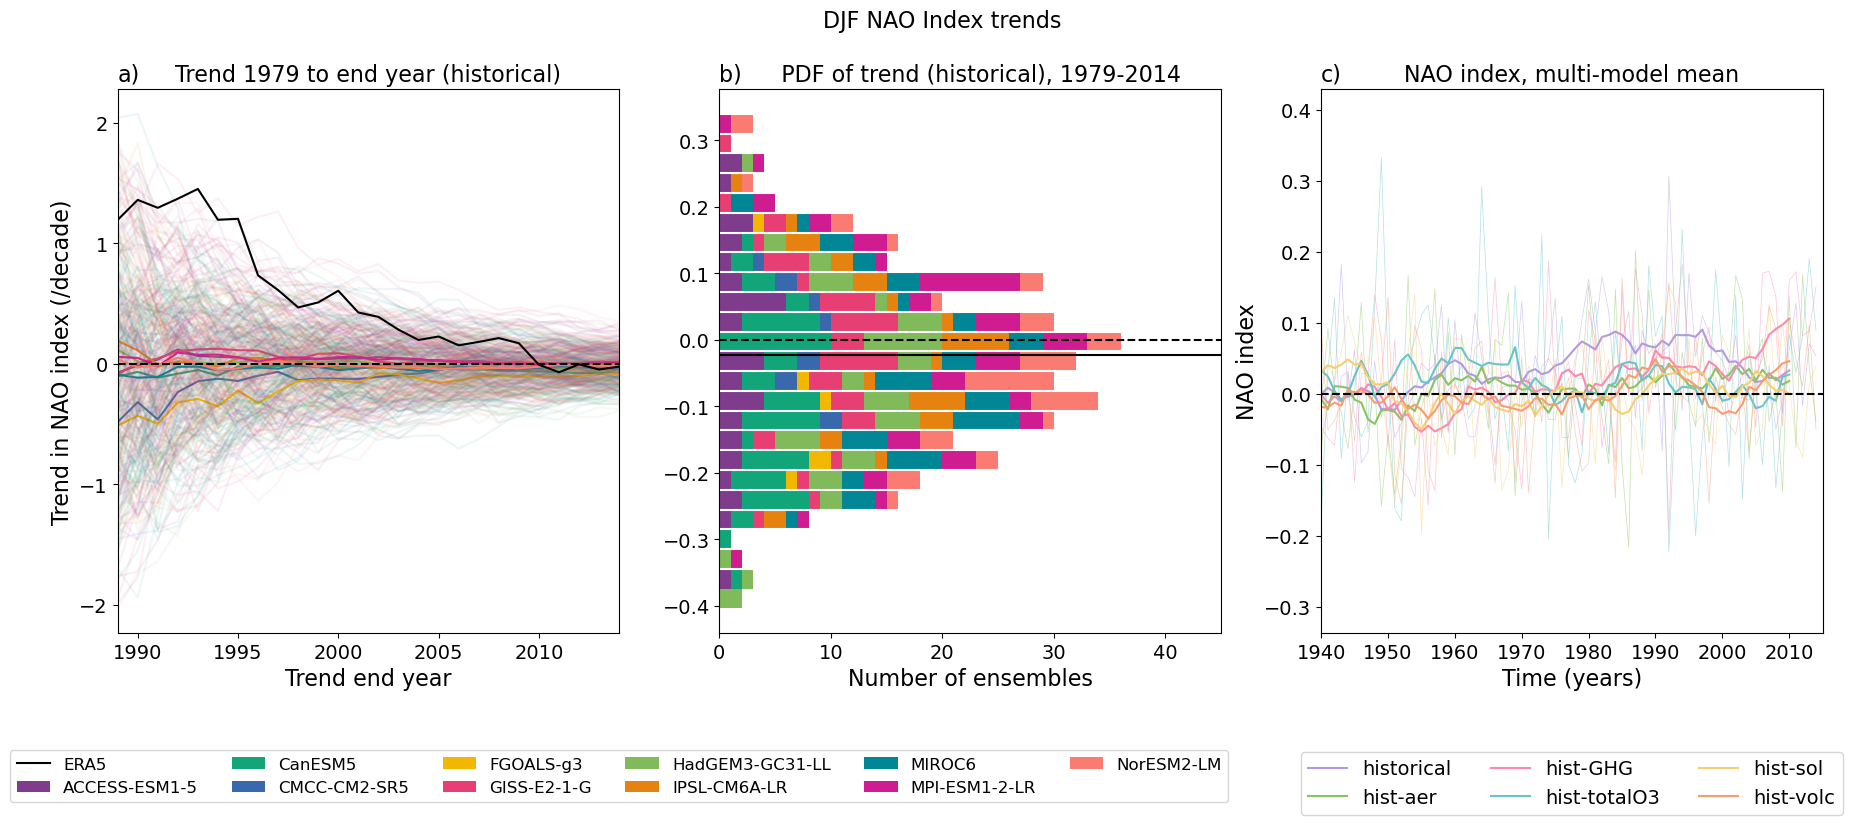

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(22,8))

#FIGURE a)
#plotting ensemble trend lines and the ensemble mean trend lines
for m in model:
    for i in range(0,len(ensembles_trend[m])):
        ax[0].plot(time,ensembles_trend[m][i], color=col_dict[m], alpha=0.075)

    ax[0].plot(time,ensemble_mean_trend[m][0], label=m, color=col_dict[m])

#plotting ERA5
ax[0].plot(time, era5_trend, color='black', label='ERA5')

#FIGURE b)
for i in range(0, len(hist_data)):
    ax[1].barh(bin_edges[:-1], hist_data[i], height=np.diff(bin_edges), left=hist_data[:i].sum(axis=0), color=colors[i], label=model[i])
    ax[1].barh(bin_edges[:-1], hist_data[i], height=np.diff(bin_edges), left=hist_data[:i].sum(axis=0), color=colors[i])

bin_width = np.abs(bin_edges[0]-bin_edges[1])

#plotting the trend hisogram
for i in range(1,len(bin_edges)):
    ax[1].axhline(bin_edges[i]+bin_width/2, color='white')

#plotting ERA5
ax[1].axhline(era5_trend_PDF.item(), color='black', label='ERA5')



#FIGURE c)
window_size = 10

for e in experiment:
    ax[2].plot(times, experiment_mmm[e], alpha=0.5, color=exp_col_dict[e], linewidth=0.5)

    running_mean_mmm = pd.Series(experiment_mmm[e]).rolling(window=window_size, center=True).mean()

    ax[2].plot(times, running_mean_mmm, label = e, color=exp_col_dict[e])
    
#plotting era5 and creating a 10-year rolling mean
era5_timeseries_running_mean = pd.Series(era5_timeseries).rolling(window=window_size, center=True).mean()

#ax[2].plot(era5_times, era5_timeseries_running_mean.values, color='black')

#FORMATTING
ax[0].axhline(0, color='black', linestyle='--')
ax[1].axhline(0, color='black', linestyle='--')
ax[2].axhline(0, color='black', linestyle='--')

ax[0].set_xlim(1989,2014)
ax[1].set_xlim(0,45)
ax[2].set_xlim(1940,2015)

#Titles and axis
ax[0].set_title('Trend 1979 to end year (historical)', fontsize=16)
ax[0].set_ylabel('Trend in NAO index (/decade)', fontsize=16)
ax[0].set_xlabel('Trend end year', fontsize=16)
ax[0].set_title('a)', loc='left', fontsize=16)
ax[0].tick_params(labelsize=14)

#creates a legend outwith the plots
a = ax[1].legend(loc='upper center', bbox_to_anchor=(-0.2, -0.2), ncols=6, fontsize=12)

ax[1].set_title('   PDF of trend (historical), 1979-2014', fontsize=16)
ax[1].set_xlabel('Number of ensembles', fontsize=16)
ax[1].set_title('b)', loc='left', fontsize=16)
ax[1].tick_params(labelsize=14)

ax[2].set_title('NAO index, multi-model mean', fontsize=16)
ax[2].set_ylabel('NAO index', fontsize=16)
ax[2].set_xlabel('Time (years)', fontsize=16)
ax[2].set_title('c)', loc='left', fontsize=16)
ax[2].tick_params(labelsize=14)

#creates a legend outwith the plots
b = ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncols=3, fontsize=14)

plt.suptitle('DJF NAO Index trends', fontsize=16)
#plt.tight_layout(rect=[0, 0.1, 1, 0.92])
plt.subplots_adjust(top=0.88, bottom=0.2)
plt.savefig('NAO_community_paper_plots_updated_projection_methodology/NAtlantic_group_paper_1979-2014_historical.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

#FIGURE a)
#plotting ensemble trend lines and the ensemble mean trend lines
for m in model:
    for i in range(0,len(ensembles_trend[m])):
        ax[0].plot(time,ensembles_trend[m][i], color=col_dict[m], alpha=0.075)

    ax[0].plot(time,ensemble_mean_trend[m][0], label=m, color=col_dict[m])

#plotting ERA5
ax[0].plot(time, era5_trend, color='black', label='ERA5')

#FIGURE b)
for i in range(0, len(hist_data)):
    ax[1].barh(bin_edges[:-1], hist_data[i], height=np.diff(bin_edges), left=hist_data[:i].sum(axis=0), color=colors[i], label=model[i])
    ax[1].barh(bin_edges[:-1], hist_data[i], height=np.diff(bin_edges), left=hist_data[:i].sum(axis=0), color=colors[i])

bin_width = np.abs(bin_edges[0]-bin_edges[1])

#plotting the trend hisogram
for i in range(1,len(bin_edges)):
    ax[1].axhline(bin_edges[i]+bin_width/2, color='white')

#plotting ERA5
ax[1].axhline(era5_trend_PDF.item(), color='black', label='ERA5 2014')




#FORMATTING
ax[0].axhline(0, color='black', linestyle='--')
ax[1].axhline(0, color='black', linestyle='--')

ax[0].set_xlim(1980,2014)
ax[1].set_xlim(0,45)

#Titles and axis
ax[0].set_title('Trend 1951 to end year (historical)', fontsize=16)
ax[0].set_ylabel('Trend in NAO index (/decade)', fontsize=16)
ax[0].set_xlabel('Trend end year', fontsize=16)
ax[0].set_title('a)', loc='left', fontsize=16)
ax[0].tick_params(labelsize=14)

#creates a legend outwith the plots
a = ax[1].legend(loc='upper center', bbox_to_anchor=(-0.2, -0.2), ncols=6, fontsize=12)

ax[1].set_title('   PDF of trend 1951-2014 (historical)', fontsize=16)
ax[1].set_xlabel('Number of ensembles', fontsize=16)
ax[1].set_title('b)', loc='left', fontsize=16)
ax[1].tick_params(labelsize=14)

plt.suptitle('DJF NAO Index trends', fontsize=16)
#plt.tight_layout(rect=[0, 0.1, 1, 0.92])
plt.subplots_adjust(top=0.88, bottom=0.2)
plt.savefig('NAO_community_paper_plots_updated_projection_methodology/NAtlantic_group_paper_1951-2014_historical_a&b.svg', bbox_inches='tight')